In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# This cell allows for all the output to be displayed without scrolling (up to the max-height var in pixels)

In [6]:
import importlib

# List of required libraries
libraries = [
    'ipywidgets',
    'IPython',
    'scipy',
    'numpy',
    'matplotlib',
    'tqdm',
    'pandas',
    'pybaselines',
    'spe2py'
]


# Check if each library is installed, and install if necessary
for library in libraries:
    try:
        importlib.import_module(library)
        print(f"{library} is already installed")
    except ImportError:
        print(f"{library} is not installed. Installing...")
        !pip install {library}
        print(f"{library} installed successfully")

# Import the required packages
from helpers import *
from ipywidgets import *
from IPython.display import display, Javascript
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks
from scipy.signal import medfilt
from scipy import signal
import peakutils
from peakutils.plot import plot as pplot
from matplotlib.animation import FuncAnimation
from scipy import stats
from numpy.fft import fft, fftfreq, ifft
import glob
from tqdm import tqdm


ipywidgets is already installed
IPython is already installed
scipy is already installed
numpy is already installed
matplotlib is already installed
tqdm is already installed
pandas is already installed
pybaselines is already installed
spe2py is not installed. Installing...
spe2py installed successfully



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
h = 6.626e-34 #Planck's constant in Js
heV = 4.136e-15 #Planck's constant in eVs
c = 2.9979e8 #Speed of light in m/s
kb = 1.381e-23 #Boltzmann constant in J/K
kbeV = 8.617e-5 #Boltzmann constant in eV/K
scale = 2e-9

In [8]:
#https://python4esac.github.io/fitting/example_blackbody.html

def blackbody_lam(lam, T):
    """ Blackbody as a function of wavelength (um) and temperature (K).

    returns units of W/m^2-nm
    """
    #from scipy.constants import h,k,c
    lam = 10**-9*lam # convert to metres
    
    fun_val = 3.14*(2*h*c**2/(lam**5*(np.exp(h*c/(lam*kb*T))-1)))/10**9
    
    return fun_val/np.max(fun_val)

In [9]:
def blackbody_lam_2(lam, T):
    """ Blackbody as a function of wavelength (um) and temperature (K).

    returns units of W/m^2-nm
    """
    #from scipy.constants import h,k,c
    lam = 10**-9*lam # convert to metres
    
    return 3.14*(2*h*c**2/(lam**5*(np.exp(h*c/(lam*kb*T))-1)))/10**9

In [40]:
def get_data_2(f):
    with open(f, 'r') as file:
        # Skip lines until the ">>>>>Begin Spectral Data<<<<<" marker is found
        for line in file:
            if line.strip() == ">>>>>Begin Spectral Data<<<<<":
                break
        
        # Read the data into a DataFrame
        data = pd.read_csv(file, sep=None, engine='python', names=['col_a_data', 'col_b_data'])
    
    x = data['col_a_data'].to_numpy()
    y = data['col_b_data'].to_numpy()

    return x, y

In [41]:
def get_data_3(f):
    
    data = pd.read_csv(f, sep=None, engine='python', names=['col_a_data','col_b_data'])
    x = data['col_a_data'].to_numpy()
    y = data['col_b_data'].to_numpy()
    
    return x,y

In [46]:
def get_data(f, i):
    with open(f[i], 'r') as file:
        # Skip lines until the ">>>>>Begin Spectral Data<<<<<" marker is found
        for line in file:
            if line.strip() == ">>>>>Begin Spectral Data<<<<<":
                break
        
        # Read the data into a DataFrame
        data = pd.read_csv(file, sep=None, engine='python', names=['col_a_data', 'col_b_data'])
    
    x = data['col_a_data'].to_numpy()
    y = data['col_b_data'].to_numpy()

    return x, y

In [43]:
def data_cleaning(data,erp):
    
    # Code to remove cosmic rays
    #erp=100 # Set percentage error limit
    err=erp/100

    Ndatapts = len(data)
    ydata = data

    for i in range(0,Ndatapts): # This loop removes hot regions one pixel wide
        if i>0 and i<Ndatapts-1:
            if ydata[i]>(1+err)*ydata[i+1] and ydata[i]>(1+err)*ydata[i-1]:
                #print('Entered the loop 1')
                ydata[i]=(ydata[i-1]+ydata[i+1])/2

    for i in range(0,Ndatapts): # This loop removes hot regions up to 3 pixels wide
        if i>1 and i<Ndatapts-2 and ydata[i]>(1+err)*ydata[i+2] and ydata[i]>(1+err)*ydata[i-2]:
            #print('Entered the loop 3')
            ydata[i], ydata[i-1], ydata[i+1] = (ydata[i-2]+ydata[i+2])/2, (ydata[i]+ydata[i-2])/2, (ydata[i+2]+ydata[i])/2

    for i in range(0,Ndatapts): # This loop removes hot regions up to 5 pixels wide
        if i>4 and i<Ndatapts-5 and ydata[i]>(1+err)*ydata[i+5] and ydata[i]>(1+err)*ydata[i-5]:
            #print('Entered the loop 3')
            ydata[i], ydata[i-1], ydata[i-2], ydata[i-3], ydata[i-4], ydata[i+1], ydata[i+2], ydata[i+3], ydata[i+4] = (ydata[i-5]+ydata[i+5])/2, (ydata[i]+ydata[i-2])/2, (ydata[i-1]+ydata[i-3])/2, (ydata[i-2]+ydata[i-4])/2, (ydata[i-3]+ydata[i-5])/2, (ydata[i+2]+ydata[i])/2, (ydata[i+3]+ydata[i+1])/2, (ydata[i+4]+ydata[i+2])/2, (ydata[i+5]+ydata[i+3])/2

    for i in range(0,Ndatapts): # This loop removes dead regions one pixel wide
        if i>0 and i<Ndatapts-1 and ydata[i]<(1-err)*ydata[i+1] and ydata[i]<(1-err)*ydata[i-1]:
            #print('Entered the loop 4')
            ydata[i]=(ydata[i-1]+ydata[i+1])/2

    for i in range(0,Ndatapts): # This loop removes dead regions up to 3 pixels wide
        if i>1 and i<Ndatapts-2 and ydata[i]<(1-err)*ydata[i+2] and ydata[i]<(1-err)*ydata[i-2]:
            #print('Entered the loop 5')
            ydata[i], ydata[i-1], ydata[i+1] =(ydata[i-2]+ydata[i+2])/2, (ydata[i]+ydata[i-2])/2, (ydata[i+2]+ydata[i])/2

    #plt.plot(wvl,ydata)
    #plt.show()
    
    return ydata

In [24]:
def subtract_bsl(data,p_order):
    
    base = peakutils.baseline(data,p_order)
    
    return base

In [25]:
def filter_savgol(data,k_size,p_order):
    
    data[np.isnan(data)] = 0
    
    sav_filt_data=signal.savgol_filter(data,k_size,p_order)
    
    return sav_filt_data

In [26]:
def filter_median(data,k_size):
    
    filt_data = medfilt(data,kernel_size=k_size)
 
    #plt.figure()
    #plt.plot(x_data,filt_data,label='Median Filtered Data')
    #plt.plot(wvl,y_data/np.max(y_data),label='Actual Data')
    #plt.plot(peak_x,peak_y/np.max(intens_data),'ob')
    #plt.title(fdata[i])
    #plt.legend()
    #plt.show()
    
    return filt_data

In [48]:
def i_corr(f,flamp):
    start = 0
    end = -1

    head_i, tail_i = os.path.split(f)
    
    ## Important note to change the location of this .txt file below to where it is in your computer.
    calibstd = np.loadtxt(r"G:\Shared drives\Pauzauskie Team Drive\Users\CG\Scripts\030410638_HL-2000-CAL_2014-01-15-14-09_VISEXT1EXT2_FIB.txt")
    xcalib = calibstd[:,0]
    ycalib = calibstd[:,1]
    
    x,y = get_data_2(f)

    # if len(fdark)!=0: #Does background correction if chosen
    #     xdark, ydark = masterRead(fdark,0)
    #     xdark=np.asarray(xdark, dtype=np.float32)
    #     ydark=np.asarray(ydark, dtype=np.float32)
    #     y=y-ydark
    HglampFunc = CubicSpline(xcalib,ycalib)
    hglampI = HglampFunc(x) # Create interpolation of true lamp spectrum

    hglampdata_x, hglampdata_y = get_data(flamp,0) # Split true lamp spectra into x and y

    ICF = hglampI/(hglampdata_y) # Creates ratio of true lamp spectra to real lamp data, ICF = Intensity Correction Factor
    #print(ICF)
    ynew = (y)*ICF # multiplies real data by intensity correction factor
    #print(ynew)
    
    ynew = np.nan_to_num(ynew,nan=0,posinf=0,neginf=0)
    datamatrix = np.column_stack((x,ynew)) # Compiles corrected data into a new matrix
    savename = tail_i[:-4]+"_calib.txt" # Create filename for new data
    #print(savename)
    # np.savetxt(os.path.join(head_i,"Calibrated_files",savename),datamatrix) # Save new data
    
    #plt.figure()
    #plt.plot(x,ynew/np.max(ynew),label='Intensity Corrected Data')
    #plt.plot(x,y/np.max(y),label='Actual Data')
    #plt.legend()
    #plt.show()

    
    return x,y,ynew

In [49]:
def data_averaging(selectFiles,average,batching, batch_size, final_file_name='-averaged_data.csv'):
    
    fdata = selectFiles.files
    
    if len(fdata) < 2:
        print("Please select at least 2 files to average")
        
    head_i, tail_i = os.path.split(fdata[0])
    y_all = []
    for idx, file in enumerate(fdata):
    
        x_data, y_data, metadata = DataReader(file_name=file).read_file()
        y_all.append(y_data)
    
    column_vectors = [np.expand_dims(arr, axis=1) for arr in y_all]

    # Concatenate the column vectors along the axis=1
    concatenated_array = np.concatenate(column_vectors, axis=1)
    average_array = concatenated_array

    average_batches = []

    if batching==True:
        # Get the total number of elements and batches
        # print(concatenated_array.shape)
        total_elements = concatenated_array.shape[1]
        total_batches = total_elements // batch_size

        # Calculate the median within each batch
        for i in range(total_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            batch_concat = np.concatenate(column_vectors[:][start_idx:end_idx], axis=1)
            batch_average = np.average(batch_concat, axis=1)
            average_batches.append(batch_average)

            # Save each batch_median to a CSV file
            batch_filename = f'-batch_average_{i+1}.csv'
            total_median_data = np.column_stack((x_data, batch_average))
            np.savetxt(os.path.join(head_i,tail_i[:-13]+batch_filename), total_median_data, delimiter=',')

    
    averaged_data = np.average(y_all, axis=1)
    total_average_data = np.column_stack((x_data, averaged_data))
    np.savetxt(os.path.join(head_i,tail_i[:-13]+final_file_name), total_average_data, delimiter=',')
    
    return x_data, averaged_data

## Clean the intensity correction data files

In [19]:
do_intensity_corr_data_cleaning = 'y'

if do_intensity_corr_data_cleaning == 'y':
    
    do_median_filtering = 'n'
    do_data_cleaning = 'n'
    erp = 10 
    k_size = 3
    
    print("\nSelect tungsten halogen (Blue Ocean optics HL2000) lamp spectrum for intensity correction \n(optional; if none is chosen, default intensity correction factor will be used): ")
    selectHalLamp_1 = SelectFilesButton()
    display(selectHalLamp_1)
else:
    pass


Select tungsten halogen (Blue Ocean optics HL2000) lamp spectrum for intensity correction 
(optional; if none is chosen, default intensity correction factor will be used): 


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))

<span style="font-family:arial; font-size:16pt;">Set the value of ***max_val_intensity*** to a number. The max of the intensity correction data should be above this value to be considered in further caluclation.
<br>
<br>
The considered intensity correction file names will be printed and saved with ***_cleaned*** at the end of the original name with *.txt* extension.</span>

100%|██████████| 1/1 [00:00<00:00, 15.63it/s]


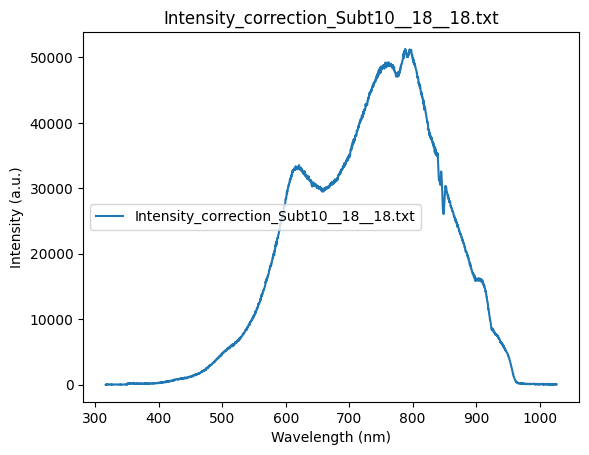

In [29]:
do_median_filtering = 'n'
do_savgol_filtering = 'n'
do_data_cleaning = 'n'
erp = 10 
k_size = 3
k_size_savgol = 51
p_order_savgol = 1
    
if do_intensity_corr_data_cleaning == 'y':

    flamp_1=selectHalLamp_1.files
    
    
    for i in tqdm(range(len(flamp_1))):
        
        head, tail = os.path.split(flamp_1[i])

        x_data,y_data = get_data(flamp_1,i)
        
        if do_savgol_filtering == 'y':
            savgol_filt_data = filter_savgol(y_data,k_size_savgol,p_order_savgol)
        else:
            savgol_filt_data = y_data

        if do_median_filtering == 'y':
            filt_data = filter_median(savgol_filt_data,k_size)
        else:
            filt_data = savgol_filt_data

        if do_data_cleaning == 'y':
            cleaned_data = data_cleaning(filt_data,erp)
        else:
            cleaned_data = filt_data
            
        max_val_intensity = 3000 ## set the value of intesnity that an intensity correction file should have to get considered

        if np.max(cleaned_data)>max_val_intensity:
            #print(flamp_1[i])

            datamatrix = np.column_stack((x_data,cleaned_data)) # Compiles corrected data into a new matrix
            savename = flamp_1[i][:-4]+"_cleaned.txt" # Create filename for new data
            np.savetxt(savename,datamatrix) # Save new data
            
            #plt.plot(x_data,y_data)
            plt.plot(x_data,cleaned_data,label=tail)
            #plt.plot(x_data,filt_data)
            #plt.plot(x_data,savgol_filt_data)
            
            plt.xlabel('Wavelength (nm)')
            plt.ylabel('Intensity (a.u.)')
            #plt.ylim(0,1000)
            plt.legend()
            #plt.ylim(100,250)
            plt.title(tail)
    plt.show()
    
else:
    pass
    

### Perform intensity correction on the spectra data files

<span style="font-family:arial; font-size:12pt;"> Use the ***_cleaned*** intensity correction file from the above and upload it in the HalLamp below.
    <br>
    <br>
    Upload the all spectra files in the first Select Files button.
    The intensity corrected spectra data files will be stored in the same folder as the original file with a ***_calib*** at the end of the name. You can use this intensity calibrated file for future use and analysis.

In [30]:
print("Select data files you want intensity corrected: ")
selectFiles = SelectFilesButton()
display(selectFiles)

do_intensity_correction = 'y'

if do_intensity_correction == 'y':
    print("Select data dark BKG: (Optional, don't use if background already subtracted)")
    selectDark = SelectFilesButton()
    display(selectDark)
    print("________________________________________________________________________________________________________")

    print("\nSelect tungsten halogen (Blue Ocean optics HL2000) lamp spectrum for intensity correction \n(optional; if none is chosen, default intensity correction factor will be used): ")
    selectHalLamp = SelectFilesButton()
    display(selectHalLamp)

    print("\nSelect baseline spectrum for tungsten lamp measurement: (Optional, don't use if background already subtracted)")
    selectBaseline = SelectFilesButton()
    display(selectBaseline)
    print("________________________________________________________________________________________________________")

else:
    pass

Select data files you want intensity corrected: 


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))

Select data dark BKG: (Optional, don't use if background already subtracted)


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))

________________________________________________________________________________________________________

Select tungsten halogen (Blue Ocean optics HL2000) lamp spectrum for intensity correction 
(optional; if none is chosen, default intensity correction factor will be used): 


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))


Select baseline spectrum for tungsten lamp measurement: (Optional, don't use if background already subtracted)


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))

________________________________________________________________________________________________________


In [50]:
## Variables

h = 6.626e-34 #Planck's constant in Js
heV = 4.136e-15 #Planck's constant in eVs
c = 2.9979e8 #Speed of light in m/s
kb = 1.381e-23 #Boltzmann constant in J/K
kbeV = 8.617e-5 #Boltzmann constant in eV/K
#pixelArea = (20e-6)*(20e-6)*100; # LN Spectrometer Area of 100, 20um x 20um pixels per wavelength
pixelArea = (14e-6)*(200e-6); # Ocean Optics UV Vis 14um x 200um per wavelength
# acquisitionTime = 0.5; # Acquisition time is seconds
acquisitionTime = 0.001 # 500ms acquistion time
#T0 = 1000 # Initial temperature guess in degrees K

do_intensity_correction = 'y'
do_baseline_subtraction = 'n'
do_median_filtering = 'n'
do_data_cleaning = 'n'
p_order = 5 # Polynomial order for baseline subtraction
k_size = 3 # Kernel size for Median Filtering
erp = -11

In [ ]:
files = glob.glob(r'H:\My Data\LH_data\05102023**\*.txt',recursive = True) 

In [ ]:
print(len(files))

  0%|          | 0/1 [00:00<?, ?it/s]

1.2982823203463074e-07


C:\Users\Pauzauskie\AppData\Local\Temp\ipykernel_1992\1559425303.py:24: RuntimeWarning: divide by zero encountered in divide
  ICF = hglampI/(hglampdata_y) # Creates ratio of true lamp spectra to real lamp data, ICF = Intensity Correction Factor
C:\Users\Pauzauskie\AppData\Local\Temp\ipykernel_1992\1559425303.py:26: RuntimeWarning: invalid value encountered in multiply
  ynew = (y)*ICF # multiplies real data by intensity correction factor


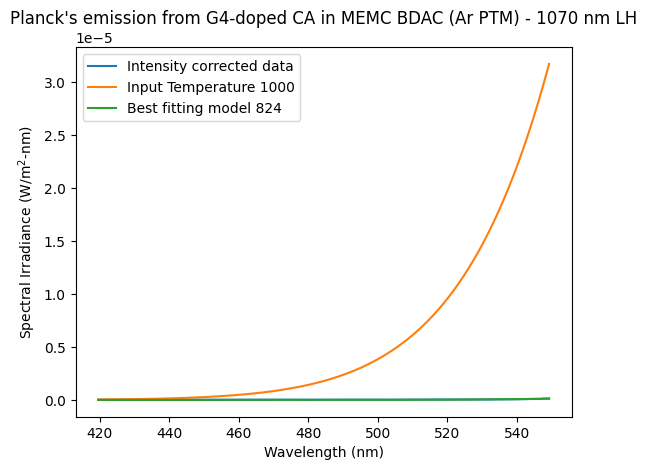

100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

                                         file_name  Temperature(K)
1  CSA_exp13_LHR3_day2__Subt2__5__10-05-53-797.txt      824.123796


In [54]:
df_1 = pd.DataFrame(columns=['file_name', 'Temperature(K)'])
counter = 0

fdata=selectFiles.files
#fdark=selectDark.files
flamp=selectHalLamp.files
#flampbase=selectBaseline.files

for file in tqdm(fdata): 
    
    # with open(file, 'r') as f:
    #     for line in f:
    #         if line.startswith('Integration Time (sec):'):
    #             integration_time = line.split(':')[1].strip()
    #             acquisitionTime = float(integration_time)
    #             # print(acquisitionTime)
    
    head, tail = os.path.split(file)
        
    #print(head)
    #print(tail)
    #print(file)
    
    counter = counter + 1

    x_data,y_data = get_data_2(file)
    # print(x_data,y_data)
    
    if do_intensity_correction == 'y':
        x_data,y_data,intens_data = i_corr(file,flamp)
    else:
        intens_data = y_data
    
    #norm_intens_data = intens_data/np.max(intens_data)
    norm_intens_data=intens_data
        
    if do_median_filtering == 'y':
        filt_data = filter_median(norm_intens_data,k_size)
    else:
        filt_data = norm_intens_data

    if do_baseline_subtraction == 'y':
        base = subtract_bsl(filt_data,p_order)
    else:
        base = 0
        
    bsl_subt_data = filt_data-base
    
    if do_data_cleaning == 'y':
        cleaned_data = data_cleaning(bsl_subt_data,erp)
    else:
        cleaned_data = bsl_subt_data
        
    # Plancks fitting process

    pixelResolution = (x_data[-1] - x_data[-2])  #delta wavelength nm
    #print('Pixel Resolution = ' + str(pixelResolution))
    
    y_spec_irr = np.zeros(shape=len(x_data))
    photonFlux = np.zeros(shape=len(cleaned_data))
    for j in range(len(x_data)):
        photonFlux[j] = cleaned_data[j]/(pixelArea*acquisitionTime)
        y_spec_irr[j] = photonFlux[j]*(h*c/(x_data[j]*10**-9))/(pixelResolution) # spectral irradiance in W/m^2-nm
    
    # y_spec_irr_norm = y_spec_irr/np.max(y_spec_irr)
    # y_spec_irr_norm = (y_spec_irr - np.min(y_spec_irr))/(np.max(y_spec_irr)-np.min(y_spec_irr))
    y_spec_irr_norm = y_spec_irr

    
    #print(x)
    start = np.argmin(abs(x_data[1:]-420))
    end = np.argmin(abs(x_data[1:]-550))
    #print(start, end)
    wa = x_data[start:end]
    ydata_1 = y_spec_irr_norm[start:end]
    ydata_1 = ydata_1
    print(max(ydata_1))

    T0 = 1000 # in K
    
    popt, pcov = curve_fit(blackbody_lam_2, wa, ydata_1, p0=T0)
        
    # get the best fitting parameter values and their 1 sigma errors
    # (assuming the parameters aren't strongly correlated).

    bestT1 = popt
    sigmaT1  = np.sqrt(np.diag(pcov))

    ybest = blackbody_lam_2(wa, bestT1)
    yblack = blackbody_lam_2(wa, T0)

    # print('True model values')
    # print('  T0 = %.2f K' % T0)

    # print('Parameters of best-fitting model:')
    # print('  T1 = %.2f K +/- %.2f K' % (bestT1, sigmaT1))

    # df_1.loc[i] = [file] + list[str(bestT1)]
    
    df_1.loc[counter] = [tail,bestT1[0]]

    # degrees_of_freedom = len(wa) - 2
    # resid = (ydata_1 - ybest) / sigmaT1
    # chisq = np.dot(resid, resid)

    # #print(degrees_of_freedom, 'dof')
    # print('chi squared %.2f' % chisq) 
    # #print('nchi2 %.2f' % (chisq / degrees_of_freedom))
    
    # plot the solution
    plt.plot(wa,ydata_1,label='Intensity corrected data')
    #plt.xlim(360,850)
    #plt.ylim(0,15)
    plt.plot(wa,yblack,label='Input Temperature %d'%T0)
    plt.plot(wa, ybest, label='Best fitting model %d'%bestT1)
    plt.title("Planck's emission from G4-doped CA in MEMC BDAC (Ar PTM) - 1070 nm LH")
    plt.ylabel("Spectral Irradiance (W/m$^2$-nm)")
    plt.xlabel("Wavelength (nm)")
    plt.legend(frameon=True)
    #plt.savefig('')
    plt.show()
print(df_1)
# df_1.to_csv(r'temp_val_2.csv',index=False,header=True)

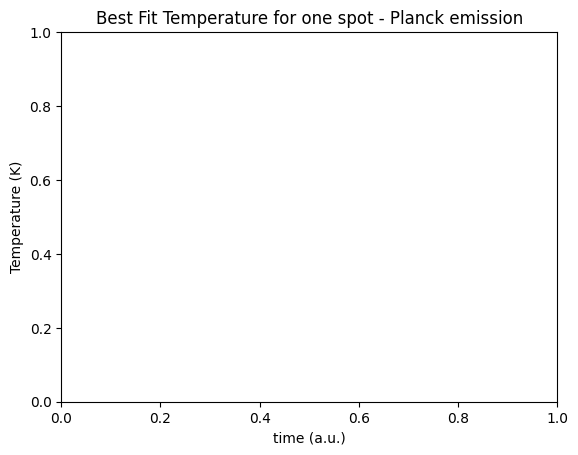

In [55]:
# df_1 = pd.read_csv('temp_val_2.csv')

x = df_1['file_name'].to_numpy()
y = df_1['Temperature(K)'].to_numpy()

#fig1 = plt.figure()
#plt.axis([0, 10, 0, 1])

#for i in range(316):
    #y = np.random.random()
for idx, yi in enumerate(y):
    if yi>1200:
        plt.scatter(idx,yi)
plt.xlabel('time (a.u.)')
plt.ylabel('Temperature (K)')
plt.title('Best Fit Temperature for one spot - Planck emission')
    #plt.pause(0.05)

plt.show()

In [ ]:
fdata=selectFiles.files
fdark=selectDark.files
flamp=selectHalLamp.files
flampbase=selectBaseline.files

for i in range(0,len(fdata)):
    
    x_data,y_data = get_data(fdata,i)
    
    #print(len(y_data))
    
    if do_intensity_correction == 'y':
        x_data,y_data,intens_data = i_corr(fdata,i)
    else:
        intens_data = y_data
    
    #norm_intens_data = intens_data/np.max(intens_data)
    norm_intens_data=intens_data
    #plt.figure()
    #plt.plot(x_data,norm_intens_data,label='Normalized Data')
    #plt.plot(x_data,y_data/np.max(y_data),label='Actual Data')
    #plt.plot(x_data,intens_data/np.max(intens_data),label='Intensity Corrected data')
    #plt.title(fdata[i])
    #plt.legend()
    #plt.show()
    
        
    if do_median_filtering == 'y':
        filt_data = filter_median(norm_intens_data,k_size)
    else:
        filt_data = norm_intens_data
        
 
    if do_baseline_subtraction == 'y':
        base = subtract_bsl(filt_data,p_order)
    else:
        base = 0
        
    bsl_subt_data = filt_data-base
    
    if do_data_cleaning == 'y':
        cleaned_data = data_cleaning(bsl_subt_data,erp)
    else:
        cleaned_data = bsl_subt_data

In [ ]:
wvl_lam = np.linspace(10,2000,10000)
temp_val = np.linspace(800,3000,22)

for i in range(len(temp_val)):
    bl_rad = blackbody_lam(wvl_lam,temp_val[i])
    
    plt.plot(wvl_lam,bl_rad,label='%d'%temp_val[i])
    plt.legend()
    
plt.show()

for j in range(len(temp_val)):
    bl_rad =  (wvl_lam,temp_val[j])
    
    plt.plot(wvl_lam,bl_rad,label='%d'%temp_val[j])
    plt.legend()
    
plt.show()